In [39]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb 
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import StratifiedKFold
#from ecgdetectors import Detectors
import pandas as pd

In [40]:
datasetdf_path = 'New data.csv'
# Read dataset into a DataFrame
datasetdf_df = pd.read_csv(datasetdf_path)

# Display the first few rows of the DataFrame
print(datasetdf_df.head())

   ecg_id  patient_id   age  sex  height  weight  nurse  site      device  \
0    4759      3250.0  39.0    1   180.0   116.0    NaN  41.0  AT-6 C 5.5   
1    9278     19350.0  60.0    1     NaN     NaN    0.0   0.0  CS100    3   
2   13398     20811.0  65.0    1     NaN     NaN    1.0   2.0       CS-12   
3   11144      1160.0  55.0    0   183.0    77.0    5.0   1.0  AT-6     6   
4     399     15234.0  40.0    0     NaN    85.0    2.0   0.0   CS-12   E   

        recording_date  ... validated_by_human baseline_drift static_noise  \
0  1990-08-11 14:18:54  ...               True            NaN          NaN   
1  1992-11-03 12:04:22  ...              False            NaN          NaN   
2  1994-11-29 11:34:41  ...               True            NaN          NaN   
3  1993-10-02 07:45:26  ...               True           , v1          NaN   
4  1987-01-17 14:16:48  ...               True            NaN          NaN   

  burst_noise electrodes_problems  extra_beats  pacemaker  strat_fol

In [41]:
def collect_and_label(dataset):
    # Collect only the MI classes and the NORM classes from the dataset.
    df = pd.read_csv(dataset)
    alpha = df['scp_codes'].str.split("'").str[1].str[-2:] == 'MI'  # Collect all the MI classes.
    beta = df['scp_codes'].str.split("'").str[1] == 'NORM'  # Collect all the Normal classes.
    df = df[alpha | beta]
    df['label'] = df['scp_codes'].str.split("'").str[1]  # Create a new column 'label' containing categorical labels.

    return df

In [42]:
df_labeled = collect_and_label('New data.csv')
print(df_labeled.head())

   ecg_id  patient_id   age  sex  height  weight  nurse  site      device  \
0    4759      3250.0  39.0    1   180.0   116.0    NaN  41.0  AT-6 C 5.5   
1    9278     19350.0  60.0    1     NaN     NaN    0.0   0.0  CS100    3   
2   13398     20811.0  65.0    1     NaN     NaN    1.0   2.0       CS-12   
3   11144      1160.0  55.0    0   183.0    77.0    5.0   1.0  AT-6     6   
4     399     15234.0  40.0    0     NaN    85.0    2.0   0.0   CS-12   E   

        recording_date  ... baseline_drift static_noise burst_noise  \
0  1990-08-11 14:18:54  ...            NaN          NaN         NaN   
1  1992-11-03 12:04:22  ...            NaN          NaN         NaN   
2  1994-11-29 11:34:41  ...            NaN          NaN         NaN   
3  1993-10-02 07:45:26  ...           , v1          NaN         NaN   
4  1987-01-17 14:16:48  ...            NaN          NaN         NaN   

  electrodes_problems extra_beats  pacemaker  strat_fold  \
0                 NaN         NaN        NaN      

In [43]:
label_counts = Counter(df_labeled['label'])
for label, count in label_counts.items():
    print(f"Label '{label}' has {count} records.")

Label 'NORM' has 2232 records.
Label 'IMI' has 1943 records.
Label 'ASMI' has 232 records.
Label 'PMI' has 1 records.
Label 'AMI' has 41 records.
Label 'ALMI' has 8 records.
Label 'LMI' has 1 records.


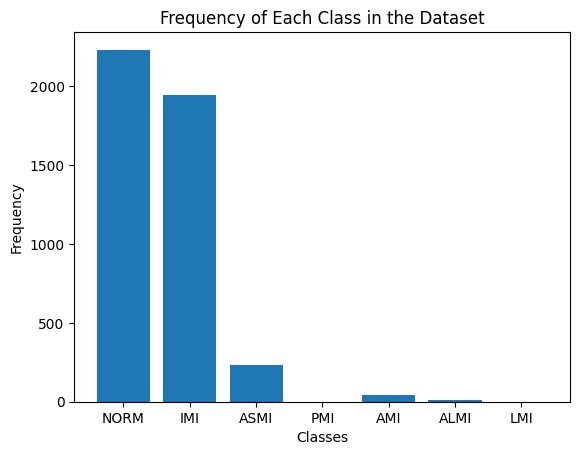

In [44]:
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Frequency of Each Class in the Dataset')
plt.show()

In [45]:
import pandas as pd

# Assuming your dataset is stored in a DataFrame called 'df'
# and the label column is named 'label'

# Filter the data to include only records with labels 'NORM' and 'IMI'
data = df_labeled[df_labeled['label'].isin(['NORM', 'IMI'])]

# Display the first few rows of the filtered data to verify
print(data.head())

   ecg_id  patient_id   age  sex  height  weight  nurse  site      device  \
0    4759      3250.0  39.0    1   180.0   116.0    NaN  41.0  AT-6 C 5.5   
1    9278     19350.0  60.0    1     NaN     NaN    0.0   0.0  CS100    3   
2   13398     20811.0  65.0    1     NaN     NaN    1.0   2.0       CS-12   
3   11144      1160.0  55.0    0   183.0    77.0    5.0   1.0  AT-6     6   
4     399     15234.0  40.0    0     NaN    85.0    2.0   0.0   CS-12   E   

        recording_date  ... baseline_drift static_noise burst_noise  \
0  1990-08-11 14:18:54  ...            NaN          NaN         NaN   
1  1992-11-03 12:04:22  ...            NaN          NaN         NaN   
2  1994-11-29 11:34:41  ...            NaN          NaN         NaN   
3  1993-10-02 07:45:26  ...           , v1          NaN         NaN   
4  1987-01-17 14:16:48  ...            NaN          NaN         NaN   

  electrodes_problems extra_beats  pacemaker  strat_fold  \
0                 NaN         NaN        NaN      

In [46]:
label_counts = Counter(data['label'])
for label, count in label_counts.items():
    print(f"Label '{label}' has {count} records.")

Label 'NORM' has 2232 records.
Label 'IMI' has 1943 records.


In [47]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
import pandas as pd

def balance_and_augment(df):
    # Augment the dataset
    smote_nc = SMOTENC(categorical_features=[1], random_state=0)
    X_res, y_res = smote_nc.fit_resample(df[['ecg_id', 'filename_hr']].to_numpy(), df['label'])
    df_balanced = pd.DataFrame(X_res, columns=['ecg_id', 'filename_hr'])
    df_balanced['label'] = y_res

    return df_balanced

In [48]:
# Collecting and labeling dataset
df_labeled = collect_and_label('New data.csv')

# Balancing and augmenting the dataset
df_balanced_and_augmented = balance_and_augment(data)

# Printing the first few rows of the resulting DataFrame
print(df_balanced_and_augmented.head())

    ecg_id                filename_hr label
0   4759.0  records500/04000/04759_hr  NORM
1   9278.0  records500/09000/09278_hr  NORM
2  13398.0  records500/13000/13398_hr  NORM
3  11144.0  records500/11000/11144_hr  NORM
4    399.0  records500/00000/00399_hr  NORM


In [49]:
label_counts = Counter(df_balanced_and_augmented['label'])
for label, count in label_counts.items():
    print(f"Label '{label}' has {count} records.")

Label 'NORM' has 2232 records.
Label 'IMI' has 2232 records.


In [50]:
df_balanced_and_augmented=df_balanced_and_augmented.sample(frac = 1 , ignore_index=True, random_state=123)

In [51]:
df_balanced_and_augmented

,ecg_id,filename_hr,label
0,7781.0,records500/07000/07781_hr,IMI
1,4036.0,records500/04000/04036_hr,NORM
2,8857.0,records500/08000/08857_hr,NORM
3,9380.0,records500/09000/09380_hr,IMI
4,14816.0,records500/14000/14816_hr,NORM
...,...,...,...
4459,18605.0,records500/18000/18605_hr,NORM
4460,18949.0,records500/18000/18949_hr,IMI
4461,18242.0,records500/18000/18242_hr,NORM
4462,15365.0,records500/15000/15365_hr,IMI


In [52]:
# Identify missing values
missing_values = df_balanced_and_augmented.isnull().sum()
print("Missing values:")
print(missing_values)  

Missing values:
ecg_id         0
filename_hr    0
label          0
dtype: int64


In [53]:
# Display the first record from the DataFrame
print(df_balanced_and_augmented.iloc[200])

ecg_id                           16073.0
filename_hr    records500/16000/16073_hr
label                               NORM
Name: 200, dtype: object


In [54]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import wfdb

# Apply Butterworth high-pass filter
def apply_highpass_filter(signal, lowcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='high')
    return filtfilt(b, a, signal)

# Function to apply high-pass filter to lead 1 at channel 0
def apply_highpass_filter_to_lead1(file_path):
    # Load ECG record
    record = wfdb.rdrecord(file_path)

    # Extract lead 1 signal (assuming it's at channel 0)
    lead_1_signal = record.p_signal[:, 0]

    # Sampling frequency
    fs = record.fs

    # Apply high-pass filter
    lowcut = 0.5  # Adjust cutoff frequency as needed
    filtered_lead_1_signal = apply_highpass_filter(lead_1_signal, lowcut, fs)

    return filtered_lead_1_signal

# Assuming 'filename_hr' contains file paths to ECG signals
file_paths = df_balanced_and_augmented['filename_hr']

# Apply high-pass filter to lead 1 at channel 0 for each file
filtered_signals = []
for file_path in file_paths:
    filtered_signal = apply_highpass_filter_to_lead1(file_path)
    filtered_signals.append(filtered_signal)

# Add filtered signals to DataFrame
df_balanced_and_augmented['filtered_lead_1_channel_0'] = filtered_signals

# Display DataFrame with filtered signals
print(df_balanced_and_augmented)


       ecg_id                filename_hr label  \
0      7781.0  records500/07000/07781_hr   IMI   
1      4036.0  records500/04000/04036_hr  NORM   
2      8857.0  records500/08000/08857_hr  NORM   
3      9380.0  records500/09000/09380_hr   IMI   
4     14816.0  records500/14000/14816_hr  NORM   
...       ...                        ...   ...   
4459  18605.0  records500/18000/18605_hr  NORM   
4460  18949.0  records500/18000/18949_hr   IMI   
4461  18242.0  records500/18000/18242_hr  NORM   
4462  15365.0  records500/15000/15365_hr   IMI   
4463   4755.0  records500/04000/04755_hr   IMI   

                              filtered_lead_1_channel_0  
0     [-0.05535706432148732, -0.055705980314489374, ...  
1     [-0.017722321193429806, -0.017834025117279443,...  
2     [-0.037288157163053365, -0.037523184698260166,...  
3     [-0.02261151421908207, -0.0227540347633655, -0...  
4     [-0.025732273877728324, -0.02587018510813184, ...  
...                                                

In [55]:
import matplotlib.pyplot as plt
from tensorflow import data 
import wfdb as sig
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras import regularizers
from sklearn.model_selection import train_test_split

In [56]:
def read_signal(record):
    tes = sig.rdrecord(record,sampfrom=0 , sampto=5000)
    signal = tes.__dict__['p_signal'][::,0]
    return signal


In [57]:
def preprocess(dat):
    data_dir = list(dat['filename_hr'])
    data_signal = map(read_signal , data_dir)
    data_signal = list(data_signal)
    data_signal = np.array(data_signal)
    data_dict = {'NORM' : 0 , 'IMI': 1  }
    encoded_label = dat['label'].map(data_dict)
    return np.array(data_signal)  , np.array(encoded_label)

In [58]:
from sklearn.model_selection import train_test_split

# Splitting data into train and (validation + test) sets
train, val_test = train_test_split(df_balanced_and_augmented, train_size=0.7, random_state=1002)

# Splitting (validation + test) into validation and test sets
validation, test = train_test_split(val_test, test_size=0.5, random_state=1002)

# Printing the sizes of train, validation, and test sets
print("Train size:", len(train))
print("Validation size:", len(validation))
print("Test size:", len(test))

Train size: 3124
Validation size: 670
Test size: 670


In [59]:
print(train.shape)
print(validation.shape)
print(test.shape)

(3124, 4)
(670, 4)
(670, 4)


In [60]:
X_train , y_train = preprocess(train)
X_valid , y_valid = preprocess(validation)
X_test  , y_test  = preprocess(test) 

In [61]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(3124, 5000)
(3124,)
(670, 5000)
(670,)
(670, 5000)
(670,)


In [62]:

# Reshape input data to add the timestep dimension
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [63]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Define the CNN model
def create_model(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Create the model
model = create_model(input_shape=X_train[0].shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a callback to save the model with the highest validation accuracy
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


# Train the model with the training and validation data
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[checkpoint])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Predict probabilities for the test set
y_pred_proba = model.predict(X_test)



Epoch 1/20


C:\Users\karim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.4912 - loss: 0.6930
Epoch 1: val_accuracy improved from -inf to 0.47761, saving model to best_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 242ms/step - accuracy: 0.4914 - loss: 0.6930 - val_accuracy: 0.4776 - val_loss: 0.6928
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5030 - loss: 0.6919
Epoch 2: val_accuracy improved from 0.47761 to 0.55075, saving model to best_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - accuracy: 0.5033 - loss: 0.6919 - val_accuracy: 0.5507 - val_loss: 0.6854
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5532 - loss: 0.6810
Epoch 3: val_accuracy improved from 0.55075 to 0.61940, saving model to best_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 232ms/step - accuracy: 0.5535 - loss: 0.6809 - val_accuracy: 0.6194 - val_loss: 0.6683
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5835 - loss: 0.6699
Epoch 4: val_accuracy did not improve from 0.6194

In [81]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, f1_score

# Define the threshold search range
thresholds = np.linspace(0, 1, 1000)

# Initialize variables to store the best threshold and corresponding metrics
best_threshold = None
best_metric_value = float('-inf')  # We want to maximize this custom metric

# Loop through each threshold and calculate corresponding metrics
for threshold in thresholds:
    y_pred_thresholded = (y_pred_proba > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_thresholded)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    
    # Custom metric: prioritize minimizing FN, then minimizing FP,
    # while maximizing TP and TN
    metric_value = TP + TN - FP - FN
    
    # Update the best threshold and best metric value if a better threshold is found
    if metric_value > best_metric_value:
        best_metric_value = metric_value
        best_threshold = threshold

# Print the best threshold and corresponding metrics
print("Best Threshold:", best_threshold)
print("Best Metric Value:", best_metric_value)

# Convert predicted probabilities to class labels using the optimal threshold
y_pred_optimal = (y_pred_proba > best_threshold).astype(int)

# Compute the confusion matrix using the optimal threshold
cm_optimal = confusion_matrix(y_test, y_pred_optimal)

# Extract TP, TN, FP, FN using the optimal threshold
TP_optimal = cm_optimal[1, 1]
TN_optimal = cm_optimal[0, 0]
FP_optimal = cm_optimal[0, 1]
FN_optimal = cm_optimal[1, 0]

# Print the number of TP, TN, FP, FN using the optimal threshold
print("True Positives with Optimal Threshold:", TP_optimal)
print("True Negatives with Optimal Threshold:", TN_optimal)
print("False Positives with Optimal Threshold:", FP_optimal)
print("False Negatives with Optimal Threshold:", FN_optimal)

# Compute precision, F1 score, sensitivity (recall), and specificity
precision_optimal = precision_score(y_test, y_pred_optimal)
f1_optimal = f1_score(y_test, y_pred_optimal)
sensitivity_optimal = TP_optimal / (TP_optimal + FN_optimal)
specificity_optimal = TN_optimal / (TN_optimal + FP_optimal)

# Print precision, F1 score, sensitivity (recall), and specificity
print("Precision with Optimal Threshold:", precision_optimal)
print("F1 Score with Optimal Threshold:", f1_optimal)
print("Sensitivity (Recall) with Optimal Threshold:", sensitivity_optimal)
print("Specificity with Optimal Threshold:", specificity_optimal)


Best Threshold: 0.4344344344344344
Best Metric Value: 310
True Positives with Optimal Threshold: 273
True Negatives with Optimal Threshold: 217
False Positives with Optimal Threshold: 108
False Negatives with Optimal Threshold: 72
Precision with Optimal Threshold: 0.7165354330708661
F1 Score with Optimal Threshold: 0.7520661157024794
Sensitivity (Recall) with Optimal Threshold: 0.7913043478260869
Specificity with Optimal Threshold: 0.6676923076923077


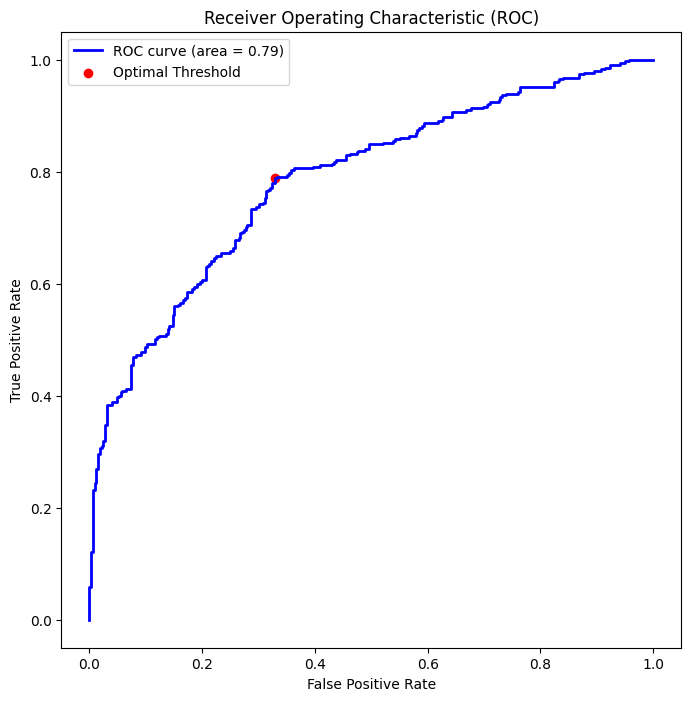

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have already computed fpr and tpr for the ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Mark optimal threshold point on ROC curve
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_threshold_index]
plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], c='red', marker='o', label='Optimal Threshold')
plt.legend()

plt.show()


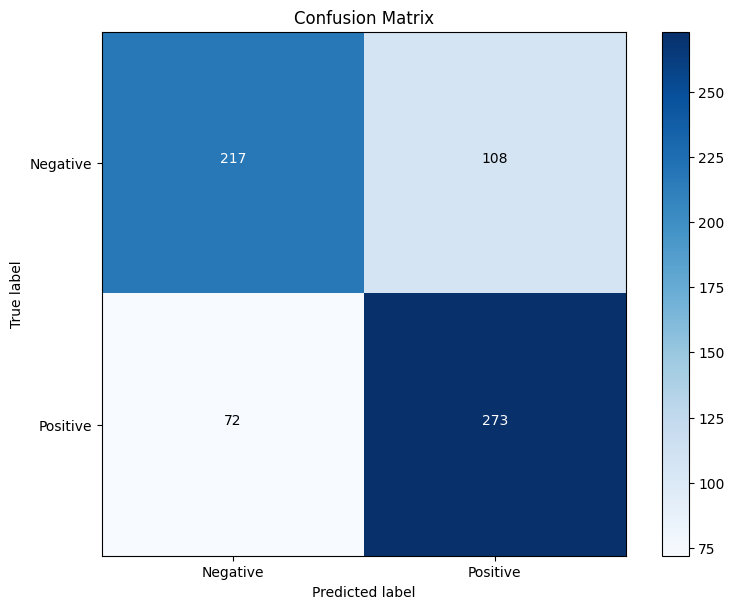

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import itertools  # Add this import for itertools
from sklearn.metrics import confusion_matrix

# Define function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define class labels
classes = ['Negative', 'Positive']

# Plot confusion matrix for optimal threshold
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm_optimal, classes)
plt.show()
